## Is it a bird, plane or Superman?

This is modification of lesson 1 [code 'Is it a bird?'](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) and lesson 2 [code](https://colab.research.google.com/drive/1M-mzhZdFQ2XWBSbLCuKzrmLsm0aLEYxQ?usp=sharing) of [Practical Deep Learning for Coders](https://course.fast.ai/) from fast.ai.

**My Insert Note**</font>s are my comments.

*   Clean up version of Lesson 1 code
*   Adding in Data augmentation as proposed in Lesson 2
*   Adding in Data cleaning as proposed in Lesson 2
*   Export model '.pkl' file as taught in Lesson 2
*   Implement Notebook App as taught in Lesson 2

Best run in [Google Colab](https://colab.research.google.com/).

In [ ]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 30.7 MB/s eta 0:00:00


In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
#fastbook.setup_book() # to connect Google Drive to Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.3 MB/s eta 0:00:00


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Step 1: Download images of birds, plane and superman

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Download a few examples of each of "bird", "f16" and "superman" photos, and save each group of photos to a different folder. And download a range of lighting conditions here:



In [ ]:
searches = 'bird', 'f16', 'superman'
path = Path('bird_plane_or_superman')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bird photo'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


Searching for 'bird sun photo'
Searching for 'bird shade photo'
Searching for 'f16 photo'
Searching for 'f16 sun photo'
Searching for 'f16 shade photo'
Searching for 'superman photo'
Searching for 'superman sun photo'
Searching for 'superman shade photo'


## Step 2: Data Augmentation

Remove photos that might not download correctly which could cause our model training to fail:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

<font color='green'>**My Insert Note:**</font> you may see nonsenical images that does not fit our search.  Data Cleaning will be coming up after learning.

In [ ]:
bird_plane_superman = DataBlock(                                # dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)                                                               #).dataloaders(path, bs=32)

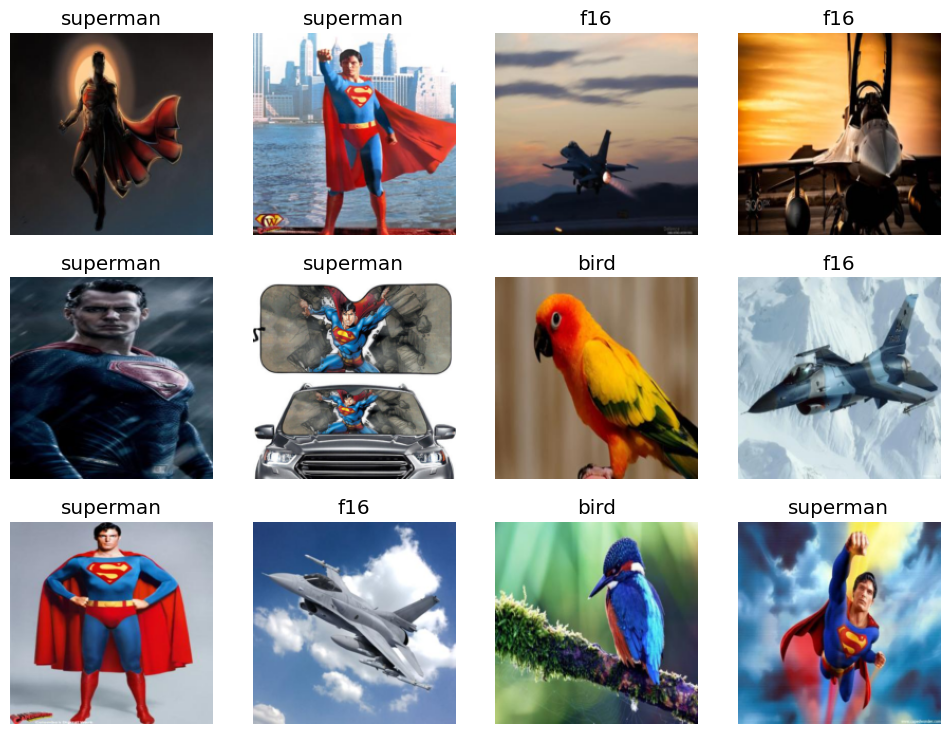

In [ ]:
dls = bird_plane_superman.dataloaders(path)
dls.show_batch(max_n=12) #Show 12 images batch

##Data Augmentation

In [ ]:
bird_plane_superman = bird_plane_superman.new(item_tfms=Resize(192), batch_tfms=aug_transforms(mult=2))

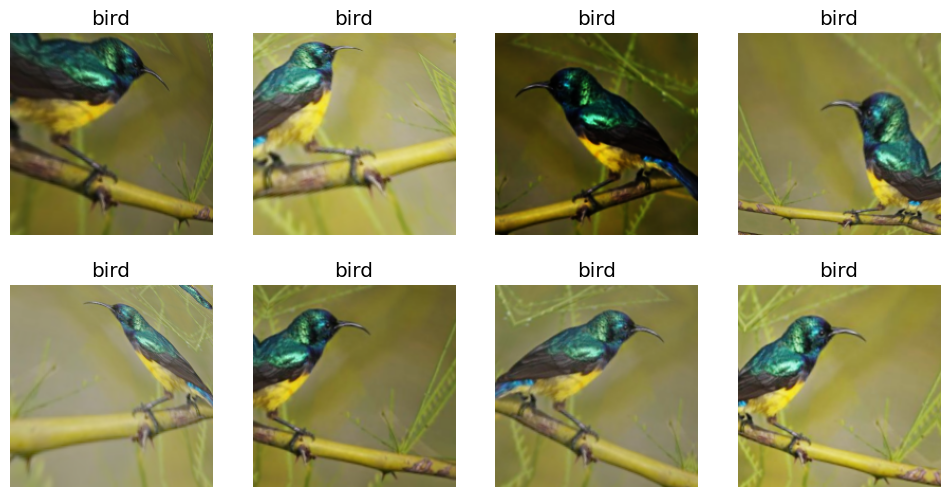

In [ ]:
dls = bird_plane_superman.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#Step 3: Train our Model

Train our model using fastest widely used computer vision model is `resnet18`.

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.244458,1.392442,0.325581,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.961642,0.416548,0.186047,00:01
1,0.773379,0.108247,0.023256,00:01
2,0.578588,0.070093,0.023256,00:01


Using Confusion Matrix to view our model accuracy

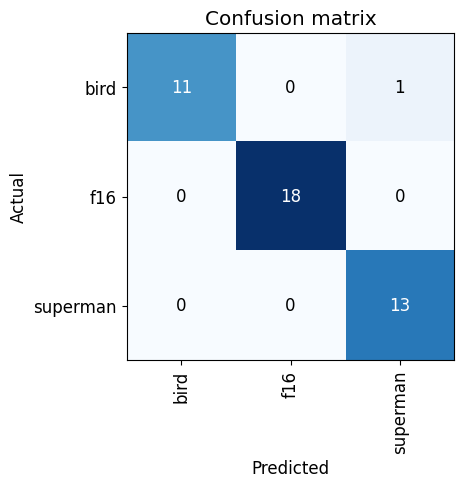

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Show our Top losses

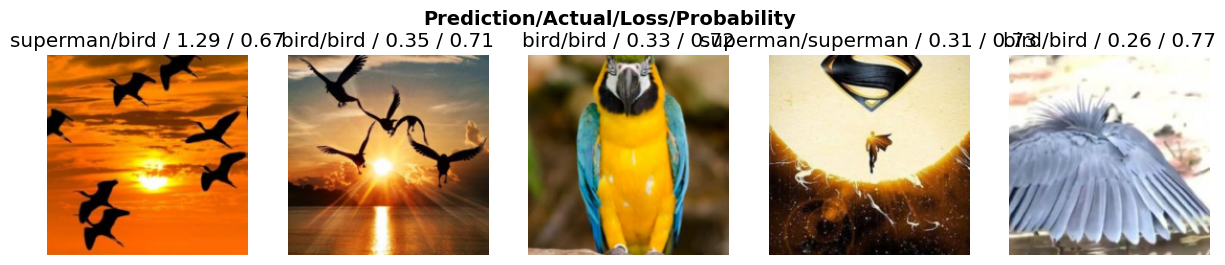

In [ ]:
interp.plot_top_losses(5, nrows=1)

## Do Data Cleaning

After change the label or Train/Valid dropdown, do wait for the widget to refresh the display

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Run this if you perform delete for each label and category

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

Run this if you did a change beside delete for each label and category

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

After this go back to 'Data Augmentation' and run the augmentation cell till here.

Repeat these steps until all data cleanse.

## Step 4: Test our Model

Using fastai widget, run the cell with `uploader` defined. It will output a button you can click, so you can select the image you want to classify:

<font color='green'>**My Insert Note:**</font> taken from '01_intro.ipynb'.  Please run this cell each time you want to upload a new picture and then click 'Upload' button.

In [ ]:
#hide_output
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

Now you can pass the uploaded file to the model. Make sure that it is a clear photo of a single bird, f16 or superman, and not a line drawing, cartoon, or similar. The notebook will tell you whether it thinks it is a bird, plane or superman, and how confident it is.

In [ ]:
img = PILImage.create(uploader.data[0])
is_bird,_,probs = learn.predict(img)
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")
print(f"Probability it's a plane: {probs[1]:.4f}")
print(f"Probability it's a superman: {probs[2]:.4f}")

This is a: f16.
Probability it's a bird: 0.0001
Probability it's a plane: 0.9996
Probability it's a superman: 0.0003


#Turning Your Model into an Online Application
##Using the Model for Inference

In [ ]:
learn.export('model.pkl')

After running the above cell, click on Colab's left panel file to download the 'model.pkl' file.

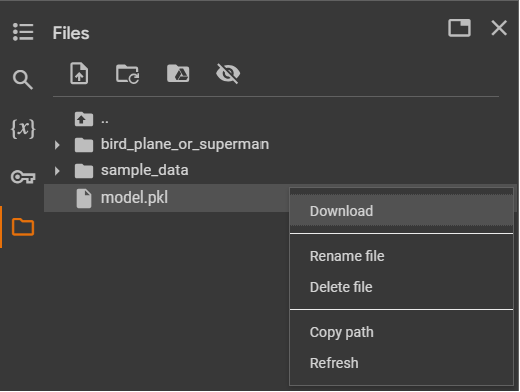

#Creating a Notebook App from the Model

Load the saved model '.pkl' file.

In [ ]:
learn_inf = load_learner('model.pkl')

##Prepare the classify function, widget button and label

Initialize an `Output` widget to display it:

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()

Initialize a Label to display the results

In [ ]:
lbl_pred = widgets.Label()

Initialize the 'Classify' button widget

In [ ]:
btn_run = widgets.Button(description='Classify')

Prepare the file Upload widget button

In [ ]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

The function to run when Classify button is pressed

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

Put them all in a vertical box (VBox) to complete our GUI:

In [ ]:
VBox([widgets.Label('Select your photo!'),
      btn_upload, btn_run, out_pl, lbl_pred])